### **Авторы:** Анастасия Ляппиева, Мария Балакаева, Сергей Шемякин 

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd 
from scipy import stats
from scipy.stats import beta, norm
from scipy.stats import t as t_distribution
from scipy.special import beta as beta_function
from scipy.special import gamma as gamma_function
np.random.seed(42)

# Часть 1





Давайте предположим модель Хестона:

$$ dS_t = (r − q)S_tdt + \sigma_t S_t dW_t $$

$$ dv_t = \kappa (\theta − v_t)dt + \nu \sqrt{v_t} dB_t $$

в риск-нейтральной мере, где $W$ и $B$ имеют корреляцию $\rho$.

### **Задание 1**

Примените метод контрольной вариации для оценки стоимости опциона forward start call 

$$(S_{T_2} - S_{T_1})^+,$$

где $T_1 < T_2$. В качестве контрольной вариации используйте выплату этого опциона в модели Блэка-Шоулза. Отчитайтесь о корреляции между выплатами в двух моделях.

In [151]:
def BS_CALL(S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def heston_forward_start(S0, T1, T2, r, q, kappa, theta, nu, rho, v0, N, M, quantle = 0.99):
    '''
    S0 --- начальная цена
    T1, T2 --- моменты времени
    r --- процентная ставка
    q, kappa, theta, nu --- параметры модели Хестона
    rho --- корреляция W и B
    v0 --- начальная дисперсия
    N --- число симуляций
    M --- шаг дискретизации
    '''
    dt = T2/M
    X = np.zeros((N, M+1)) #X = ln(S)
    S = np.zeros((N, M+1))
    v = np.zeros((N, M+1))
    S[:,0] = S0
    X[:,0] = np.log(S0)
    v[:,0] = v0
    
    for i in range(1, M+1):
        Z1 = np.random.normal(size=N)
        Z2 = rho*Z1 + np.sqrt(1-rho**2)*np.random.normal(size=N)
        v[:,i] = v[:,i-1] + kappa*(theta - np.maximum(v[:,i-1], 0))*dt + nu*np.sqrt(np.maximum(v[:,i-1], 0)*dt)*Z1
        X[:,i] = X[:,i-1] + (r-q-0.5*np.maximum(v[:,i-1], 0))*dt + np.sqrt(np.maximum(v[:,i-1], 0)*dt)*Z2
        S[:,i] = np.exp(X[:,i])
    idx_T1 = int(T1/dt)
    idx_T2 = M
    Y = np.maximum(S[:,idx_T2] - S[:,idx_T1], 0)  # Хестон
    payoff = Y
    price = np.exp(-r * T2) * payoff.mean(), np.exp(-r * T2) * payoff.std() * t_distribution.ppf(quantle, N-1) / np.sqrt(N)
    return price

def heston_forward_start_reduced(S0, T1, T2, r, q, kappa, theta, nu, rho, v0, N, M, sigma_BS, quantle = 0.99):
    '''
    S0 --- начальная цена
    T1, T2 --- моменты времени
    r --- процентная ставка
    q --- дивиденды
    kappa, theta, nu --- параметры модели Хестона
    rho --- корреляция W и B
    v0 --- начальная дисперсия
    N --- число симуляций
    M --- шаг дискретизации
    '''
    dt = T2/M
    X = np.zeros((N, M+1)) #X = ln(S)
    S = np.zeros((N, M+1))
    v = np.zeros((N, M+1))
    S[:,0] = S0
    X[:,0] = np.log(S0)
    v[:,0] = v0

    idx_T1 = int(T1/dt)
    idx_T2 = M
    
    for i in range(1, M+1):
        Z1 = np.random.normal(size=N)
        Z2 = rho*Z1 + np.sqrt(1-rho**2)*np.random.normal(size=N)
        v[:,i] = v[:,i-1] + kappa*(theta - np.maximum(v[:,i-1], 0))*dt + nu*np.sqrt(np.maximum(v[:,i-1], 0)*dt)*Z1
        X[:,i] = X[:,i-1] + (r-q-0.5*np.maximum(v[:,i-1], 0))*dt + np.sqrt(np.maximum(v[:,i-1], 0)*dt)*Z2
        S[:,i] = np.exp(X[:,i])
        if i == idx_T1:
            Z_BS = Z2
    
    Y = np.maximum(S[:,idx_T2] - S[:,idx_T1], 0)  # Хестон
    
    Z3 = rho*Z_BS + np.sqrt(1-rho**2)*np.random.normal(size=N)
    Z4 = rho*Z2 + np.sqrt(1-rho**2)*np.random.normal(size=N)
    S_BS_T1 = S0 * np.exp((r - q - sigma_BS ** 2 / 2) * T1 + sigma_BS * np.sqrt(T1) * Z3)
    S_BS_T2 = S_BS_T1 * np.exp((r - q - sigma_BS ** 2 / 2) * (T2-T1) + sigma_BS * np.sqrt((T2-T1)) * Z4)

    Z = np.max([S_BS_T2 - S_BS_T1, np.zeros(N)], axis=0)
    m = BS_CALL(S_BS_T1, S_BS_T1, T2 - T1, r, q, sigma_BS) * np.exp(- r * T1)
    b = np.cov(Y, Z)[0,1]/np.var(Z)
    payoff = Y - b*(Z - m)
    return [np.exp(-r * T2) * payoff.mean(), np.exp(-r * T2) * payoff.std() * t_distribution.ppf(quantle, N-1) / np.sqrt(N), np.corrcoef(payoff, Z)[0][1]]

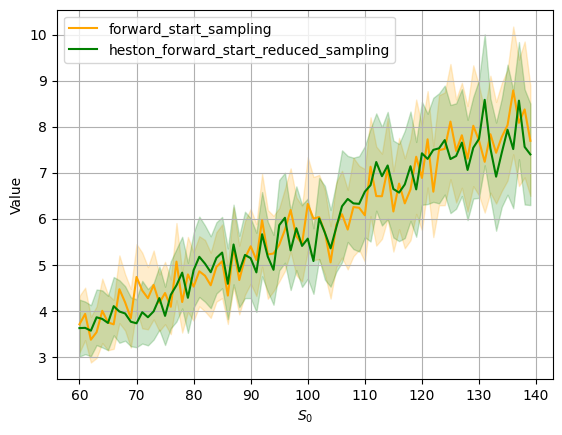

In [152]:
S = np.arange(60,140,1)
T1 = 1
T2 = 2
r = 0.05
q = 0.01
kappa = 0.01
theta = 0.1
nu = 0.1
rho = 0.5
v = 0.01
N = 500
M_naive = 10
M_smart = 10
sigma_BS = 0.1

forward_start_sampling = np.array([heston_forward_start(s, T1, T2, r, q, kappa, theta, nu, rho, v, N, M_naive) for s in S])
heston_forward_start_reduced_sampling = np.array([heston_forward_start_reduced(s, T1, T2, r, q, kappa, theta, nu, rho, v, N, M_smart, sigma_BS) for s in S])
plt.plot(S, forward_start_sampling[:,0], label='forward_start_sampling', color = 'orange')
plt.fill_between(S, forward_start_sampling[:,0] + forward_start_sampling[:,1], forward_start_sampling[:,0] - forward_start_sampling[:,1], alpha=0.2, color = 'orange')
plt.plot(S, heston_forward_start_reduced_sampling[:,0], label='heston_forward_start_reduced_sampling', color = 'green')
plt.fill_between(S, heston_forward_start_reduced_sampling[:,0] + heston_forward_start_reduced_sampling[:,1], heston_forward_start_reduced_sampling[:,0] - heston_forward_start_reduced_sampling[:,1], alpha=0.2, color = 'green')
plt.xlabel('$S_0$')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

Text(0.5, 1.0, 'Correlation')

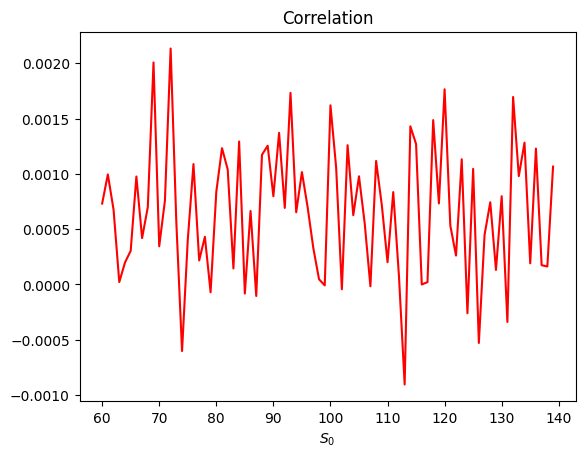

In [153]:
plt.plot(S, heston_forward_start_reduced_sampling[:,2], color = 'red')
plt.xlabel('$S_0$')
plt.title("Correlation")

### **Задание 2**
Примените условный метод Монте-Карло для оценки стоимости европейского call-опциона.

Для этого cгенерируйте траектории $\sigma_t^{(n)}$ для $n = 1, ..., N$ с $m$ шагами дискретизации и условно на этих траекториях используйте формулу для call-опциона в модели Блэка-Шоулза с зависящей от времени волатильностью. В данном вопросе можно предположить, что $\rho = 0$.

Затем вычислите среднее:

$$C_{Heston} = \frac{1}{N} \sum_{n = 1}^N C_{BS}(\sigma^{(n)})$$
 Выберите конкретные параметры и постройте таблицу цен опциона для различных пар $(N, m)$.

In [154]:
def BS_CALL_sigma_time_dep(S, K, T, r, q, sigma):
    sigma_new = 1/np.sqrt(T * sigma.shape[1]) * np.sqrt(np.sum(sigma**2, axis = 1))
    d1 = (np.log(S/K) + (r - q + 0.5 * sigma_new**2) * T) / (sigma_new * np.sqrt(T))
    d2 = d1 - sigma_new * np.sqrt(T)
    return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def heston_call_option_approximation_from_BS(S0, K, T, r, q, kappa, theta, nu, v0, N, M, quantle = 0.99):
    '''
    S0 --- начальная цена
    r --- процентная ставка
    T --- экспирация
    q --- дивиденды
    kappa, theta, nu --- параметры модели Хестона
    rho --- корреляция W и B
    v0 --- начальная дисперсия
    N --- число симуляций
    M --- шаг дискретизации
    '''
    dt = T/M
    v = np.zeros((N, M+1))
    v[:,0] = v0
    
    for i in range(1, M+1):
        Z1 = np.random.normal(size=N)
        v[:,i] = v[:,i-1] + kappa*(theta - np.maximum(v[:,i-1], 0))*dt + nu*np.sqrt(np.maximum(v[:,i-1], 0)*dt)*Z1

    C_BS = BS_CALL_sigma_time_dep(S0, K, T, r, q, np.sqrt(v))

    payoff = C_BS
    # price = np.exp(-r * T) * payoff.mean(), np.exp(-r * T) * payoff.std() * t_distribution.ppf(quantle, N-1) / np.sqrt(N)
    price = np.exp(-r * T) * payoff.mean()
    return price


In [155]:

S0 = 100  
r = 0.05  
q = 0.0
kappa = 0.1
theta = 0.01
nu = 0.1
rho=0
v = 1
K = 100
T = 1

num_sim = np.arange(100, 10000, 100)
num_step = [10, 50, 100]  

results = np.zeros((len(num_step), len(num_sim)))

for i, m in enumerate(num_step):
    for j, N in enumerate(num_sim):
        results[i, j] = heston_call_option_approximation_from_BS(S0, K, T, r, q, kappa, theta, nu, v, N, m)

table = pd.DataFrame(results)
table.columns = num_sim
table.index = num_step
table



,100,200,300,400,500,600,700,800,900,1000,...,9000,9100,9200,9300,9400,9500,9600,9700,9800,9900
10,36.886462,37.131800,37.090690,37.052622,37.025801,37.101014,37.056557,37.123093,37.075008,37.033554,...,37.079074,37.092929,37.074455,37.073583,37.092735,37.079755,37.085469,37.092861,37.085450,37.087166
50,37.016156,37.024766,37.097775,37.143177,37.146875,37.098758,37.131835,37.111404,37.092141,37.082633,...,37.090190,37.092315,37.092491,37.085521,37.093028,37.090794,37.097336,37.090481,37.093274,37.086302
100,36.940138,37.077134,37.020719,37.011284,37.078237,37.097090,37.093525,37.119338,37.108482,37.024371,...,37.071087,37.078023,37.089753,37.090538,37.088956,37.078659,37.097822,37.097626,37.072081,37.077214


# Часть 2



Давайте рассмотрим цены $d$ активов, описываемые геометрическим броуновским движением в риск-нейтральной мере Q:

$$dS_t^i = (r - \delta_i)S_t^idt + \sigma_i S_t^i dW_t^i,$$

где $r$ - безрисковая процентная ставка, $\delta_i$ - дивидендная доходность актива $i$, $\sigma_i$ - волатильность актива $i$, $W^i$ - стандартные броуновские движения (винеровские процессы) в мере Q с кросс-корреляциями $\rho_{i, j}$.

Параметры: $r$ = 0.05, $\delta_i$ = 0.02, $\sigma_i$ = 0.3, $\rho_{i, j}$ = 0.2 для всех $i, j$.

Используйте метод Монте-Карло для оценки следующих многокомпонентных опционов:

### **Задание 1**

Европейский баскет опцион с выплатой 

$$(S_T^1 + S_T^2 - S_T^3 - K)^+ ,$$

где $S_0^1 = S_0^2 = S_0^3 = K = 100$, $T = 1$.

**Комментарии по решению**

Для симуляции коррелированных броуновских движений используем разложение Холецкого для ковариационной матрицы $С$, т.е. ищем такую матрицу $L$, что $С = LL^T$. Элементы матрицы $L$ равны:

$$L_{11} = 1, L_{21} = 0.2, L_{31} = 0.2, L_{22} = \sqrt{0.96}, L_{32} = \frac{0.16}{\sqrt{0.96}}, L_{33} = \sqrt{0.96 - (L_{32})^2}.$$

После чего симулируем коррелированные броуновские движения следующим образом:

$$dW_t^1 = \sqrt{dt} Z_1,$$

$$dW_t^2 = \sqrt{dt} (0.2 Z_1 + \sqrt{0.96} Z_2),$$

$$dW_t^3 = \sqrt{dt} (0.2 Z_1 + \frac{0.16}{\sqrt{0.96}} Z_2 + \sqrt{0.96 - (L_{32})^2} Z_3),$$

где $Z_1, Z_2, Z_3$ - независимые стандартные нормальные случайные величины.

In [156]:
def basket_option_european(S0_1, S0_2, S0_3, K, T, r, delta, sigma, N):
    
    Z1 = np.random.normal(size=N)
    Z2 = np.random.normal(size=N)
    Z3 = np.random.normal(size=N)

    ST_1 = S0_1 * np.exp((r - delta - sigma ** 2 / 2) * T + sigma * np.sqrt(T) * Z1)
    ST_2 = S0_2 * np.exp((r - delta - sigma ** 2 / 2) * T + sigma * np.sqrt(T) * (0.2 * Z1 + np.sqrt(0.96) * Z2))
    ST_3 = S0_3 * np.exp((r - delta - sigma ** 2 / 2) * T + sigma * np.sqrt(T) * (0.2 * Z1 + 0.16 / np.sqrt(0.96) * Z2 + np.sqrt(0.96 - (0.16 / np.sqrt(0.96))**2) * Z3))

    payoff = np.maximum(ST_1 + ST_2 - ST_3 - K, 0)

    price = np.exp(-r * T) * payoff.mean()

    return price, np.exp(-r * T) * payoff.std() * t_distribution.ppf(0.99, N-1) / np.sqrt(N)


In [157]:
S0_1 = 100
S0_2 = 100
S0_3 = 100
K = 100
T = 1
r = 0.05
delta = 0.02
sigma = 0.3

num_sim = np.arange(100, 10001, 1000) 
results = []

for N in num_sim:
    price, error = basket_option_european(S0_1, S0_2, S0_3, K, T, r, delta, sigma, N)
    results.append({
        'N': N,
        'Price': price,
        'Error': error
    })

df = pd.DataFrame(results)
# horizontal_table = df.set_index('N').T
display(df.set_index('N').T)


N,100,1100,2100,3100,4100,5100,6100,7100,8100,9100
Price,19.868153,20.413207,21.212024,19.793978,21.227308,19.927845,20.469066,20.945681,20.136724,20.373923
Error,6.534194,2.226648,1.628898,1.286050,1.177765,1.024122,0.953257,0.882008,0.796861,0.765444


### **Задание 2**

Бермудский опцион на корзину активов с выплатой (с использованием метода Монте-Карло с наименьшими квадратами):

$$(S_{\tau}^1 + S_{\tau}^2 - S_{\tau}^3 - K)^+ ,$$

где $S_0^1 = S_0^2 = S_0^3 = K = 100$, $T = 1$.

Этот контракт может быть исполнен в моменты времени $t_i = i/12, i = 1, ..., 12$.

Сгенерируйте нижнюю границу, где политика исполнения задана методом, основанным на регрессии. Выберите набор базисных функций. Сообщите цену опциона и 95% доверительный интервал для разного числа симуляций.

In [158]:

def basket_option_bermudan(S0_1, S0_2, S0_3, K, T, r, divs, sigma, N, M = 12):
    print(N)
    def psi_1_f(S_i_1, S_i_2, S_i_3):
        return S_i_1 + S_i_2 + S_i_3

    def psi_2_f(S_i_1, S_i_2, S_i_3):
        return (S_i_1 + S_i_2 + S_i_3)**2

    def psi_3_f(S_i_1, S_i_2, S_i_3):
        return (S_i_1 + S_i_2 + S_i_3)**3

    def CV(psi, r, dt, beta_i):
        return np.exp(-r*dt)*(psi[0,:]*beta_i[0] + psi[1,:]*beta_i[1] + psi[2,:]*beta_i[2])

    dt = T / M

    S_1 = np.zeros((N, M+1))
    S_2 = np.zeros((N, M+1))
    S_3 = np.zeros((N, M+1))
    S_1[:, 0] = S0_1
    S_2[:, 0] = S0_2
    S_3[:, 0] = S0_3

    for i in range (1, M+1):
        Z1 = np.random.normal(size=N)
        Z2 = np.random.normal(size=N)
        Z3 = np.random.normal(size=N)
        
        S_1[:, i] = S_1[:, i-1] * np.exp((r - divs - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * Z1)
        S_2[:, i] = S_2[:, i-1] * np.exp((r - divs - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * (0.2 * Z1 + np.sqrt(0.96) * Z2))
        S_3[:, i] = S_3[:, i-1]* np.exp((r - divs - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * (0.2 * Z1 + 0.16 / np.sqrt(0.96) * Z2 + np.sqrt(0.96 - (0.16 / np.sqrt(0.96))**2) * Z3))

    V = np.zeros((N, M+1))
    V[:, -1] = np.maximum(S_1[:, -1] + S_2[:, -1] - S_3[:, -1] - K, 0)
    beta_estimated = []

    for i in range(M - 1, 0, -1):
        psi_1 = psi_1_f(S_1[:, i], S_2[:, i], S_3[:, i])
        psi_2 = psi_2_f(S_1[:, i], S_2[:, i], S_3[:, i])
        psi_3 = psi_3_f(S_1[:, i], S_2[:, i], S_3[:, i])
        psi = np.vstack((psi_1, psi_2, psi_3))
        B_psi = psi @ psi.T
        beta_estimated.append(np.linalg.inv(B_psi) @ psi @ V[:, i + 1])
        V[:, i] = np.maximum(
            np.maximum(S_1[:, i] + S_2[:, i] - S_3[:, i] - K, 0), CV(psi, r, dt, beta_estimated[-1])
        )
    V[:, 0] = np.exp(-r*dt) * V[:, 1]

    payoff = V[:, 0]
    return price.mean(), np.exp(-r * T) * payoff.std() * t_distribution.ppf(0.99, N-1) / np.sqrt(N)


In [159]:
S_0, S_1, S_2 = 100, 100, 100
K=100
T=1
r=0.05
divs=0.02 
sigma=0.3

# num_sim = np.arange(100, 10001, 1000) 
num_sim = np.arange(1_000, 1_101_000, 100_000) 
results = []

for N in num_sim:
    price, error = basket_option_bermudan(
        S0_1, S0_2, S0_3, K, T, r, divs, sigma, N
    )
    results.append({
        'N': N,
        'Price': price,
        'Error': error
    })

df = pd.DataFrame(results)

display(df.set_index('N').T)

1000
101000
201000
301000
401000
501000
601000
701000
801000
901000
1001000


N,1000,101000,201000,301000,401000,501000,601000,701000,801000,901000,1001000
Price,20.373923,20.373923,20.373923,20.373923,20.373923,20.373923,20.373923,20.373923,20.373923,20.373923,20.373923
Error,0.573944,0.056275,0.039735,0.032625,0.028235,0.025250,0.023014,0.021254,0.019872,0.018798,0.017784


# Часть 3

Сallable Reverse Convertible


## Условия контракта

1. **Параметры**:
   - Начальные цены активов: $ S_0^1 = S_0^2 = 100 $
   - Номинал: $ K = 100 $
   - Срок: $ T = 2 $ года
   - Число купонных выплат: $ n = 8 $ 
   - Даты выплат: $ t_i = \frac{iT}{n} $, $ i = 1,...,8 $

2. **Потоки платежей**:
   - **Купоны**: выплата $ c $ в каждую дату $ t_i $
   - **Досрочное погашение**: эмитент может погасить контракт в даты $ t_1,...,t_{n-1} $, выплачивая $ c + K $
   - **Терминальная выплата** (если не было досрочного погашения):
     - Если $ \min(S_T^1, S_T^2) \geq K $: выплата $ c + K $
     - Если $ \min(S_T^1, S_T^2) < K $: выплата $ c + \min(S_T^1, S_T^2) $

## Моделирование активов

Цены активов описываются CEV-моделью:
$
\begin{cases}
dS_t^1 = rS_t^1dt + \sigma_1(S_t^1)^{\gamma_1}dW_t^1 \\
dS_t^2 = rS_t^2dt + \sigma_2(S_t^2)^{\gamma_2}dW_t^2
\end{cases}
$
где:
- $ (W_t^1, W_t^2) $ - коррелированные броуновские движения с коэффициентом $ \rho $
- $ \gamma_1, \gamma_2 $ - параметры elasticity (обычно $ \gamma_i \in (0,1] $)

## Задача 

Определить размер купона $ c $, при котором начальная стоимость контракта $ V_0 = 100 $.

## Метод решения

1. **Моделирование траекторий**:
   - Дискретизация CEV-модели с коррелированными шумами
   - Генерация $ N $ траекторий с $ m $ шагами дискретизации

2. **Оценка оптимального стратегии досрочного погашения**:
   - Применение метода Longstaff-Schwartz (LSM)
   - Регрессия
   - Базисные функции: полиномы до 2-й степени

3. **Определение купона**:
   - Итеративный поиск $ c $ методом бисекции




In [160]:


def simulate_cev(S0, r, sigma, gamma, T, m, N, rho):
    dt = T/m
    Z = np.random.normal(size=(2, m, N))
    Z[1] = rho*Z[0] + np.sqrt(1-rho**2)*Z[1]

    # [2 актива, m шагов, N траекторий]
    S = np.zeros((2, m+1, N))

    S[:,0,:] = np.array(S0)[:, np.newaxis]  # Форма (2,1) -> (2,10000) через broadcasting
    # S[:,0,:] = S0
    
    for t in range(1, m+1):
        dW = np.sqrt(dt)*Z[:,t-1,:]
        #(i=0 — первый актив, i=1 — второй)
        for i in [0,1]:           
            drift = r * S[i,t-1,:] * dt
            diffusion = sigma[i] * (S[i,t-1,:]**gamma[i]) * dW[i,:]
            S[i,t,:] = S[i,t-1,:] + drift + diffusion
    
    return S

In [161]:
def lsm_american_option(S, K, r, T, m, coupon, exercise_dates):

    # извлекаем количество траекторий моделирования из массива цен S
    N = S.shape[2]
    dt = T/m
    discount = np.exp(-r*dt)
    
    # Выплаты
    H = np.zeros((m+1, N))
    for t in exercise_dates:
        # Переводим время t в индекс матрицы:
        idx = int(t/dt)
        H[idx,:] = coupon + K
    
    # [2 актива, m шагов, N траекторий]
    min_prices = np.min(S[:,m,:], axis=0)
    H[m,:] = np.where(min_prices >= K, coupon + K, coupon + min_prices)
    
    # Обратная индукция
    V = np.copy(H)
    for i in range(m-1, 0, -1):
        # является ли текущий шаг i датой досрочного погашения
        if i in [int(t/dt) for t in exercise_dates]:
            in_money = np.where(H[i,:] > 0)[0] # Longstaff and Schwartz -- из лекции
            X = S[:,i,in_money].T              # Цены активов (N_in x 2)
            Y = discount * V[i+1,in_money]     # Дисконтированные значения (N_in,)
            
            # Создаем матрицу базисных функций Psi (N x M)
            M = 6
            Psi = np.ones((len(in_money), M))

            Psi[:,1] = X[:,0]         # S1
            Psi[:,2] = X[:,1]         # S2
            Psi[:,3] = X[:,0]**2      # S1^2
            Psi[:,4] = X[:,1]**2      # S2^2
            Psi[:,5] = X[:,0]*X[:,1]  # S1*S2
            
            # Явное решение по формуле из лекции
            B_psi = Psi.T @ Psi  # M x M матрица
            rhs = Psi.T @ Y      # M-вектор
            
            try:
                beta = np.linalg.solve(B_psi, rhs)  # Решаем СЛАУ
            except np.linalg.LinAlgError:
                beta = np.zeros(M)  # Если матрица вырождена
            

            # beta = [β₀, β₁, β₂, β₃, β₄, β₅] 
            # β₀ + β₁*S_1^1 + β₂*S_2^1 + ...    # Для траектории 0
            # β₀ + β₁*S_1^2 + β₂*S_2^2 + ...    # Для траектории 1
            # β₀ + β₁*S_1^3 + β₂*S_3^3 + ...    # Для траектории 2

            continuation = Psi @ beta
            
            exercise = H[i,in_money]
            V[i,in_money] = np.where(exercise > continuation, 
                                   exercise, 
                                   discount*V[i+1,in_money])
        else:
            V[i,:] = discount * V[i+1,:]
    
    return np.mean(discount * V[1,:])

In [162]:
def find_coupon(S, K, r, T, m, N, exercise_dates, target_price=100, eps=0.01):
    c_low, c_high = 0, 50
    for _ in range(100):
        c_mid = (c_low + c_high)/2
        price = lsm_american_option(S, K, r, T, m, c_mid, exercise_dates)
        
        if abs(price - target_price) < eps:
            return c_mid
        elif price < target_price:
            c_low = c_mid
        else:
            c_high = c_mid
    
    return c_mid

In [163]:
S0 = [100, 100]  
K = 100          
r = 0.05         
sigma = [0.2, 0.3]  
gamma = [0.8, 0.9] 
rho = 0.5        
T = 2            
n = 8            
exercise_dates = np.linspace(T/n, T-T/n, n-1)  # Даты досрочного погашения


N = 10000        # Число траекторий
m = 100          # Число шагов дискретизации

S = simulate_cev(S0, r, sigma, gamma, T, m, N, rho)

coupon = find_coupon(S, K, r, T, m, N, exercise_dates)
print(f"Значение купона c, делающее V0=100: {coupon:.4f}")

Значение купона c, делающее V0=100: 1.2085
